In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import tensorflow as tf  # pylint: disable=g-bad-import-order
import numpy as np

#Path to "official" tensorflow models directory
sys.path.append("../tf/models/")
from official.utils.arg_parsers import parsers
from official.utils.export import export
from official.utils.logging import hooks_helper
from official.utils.logging import logger

sys.path.append("..")
import resnet_ncm as resnet
import resnet_deepncm_run_loop as rrl
import cifar10_deepncm as c10

In [4]:
ALLOW_MULTIPLE_MODELS = True

# Code from cifar10_ncmnet.py

In [5]:
ds = 'cifar10'
c10.set_DS_global(ds)
DS = c10.set_dataset(ds)

set_dataset
set_dataset


In [6]:
parser = rrl.ResnetArgParser()
parser.set_defaults(resnet_size=32,
                      train_epochs=250,
                      epochs_between_evals=1,
                      batch_size=128,
                      )
flags = parser.parse_args(["--dataset","cifar10","--ncmmethod","onlinemean","--ncmparam","10","-l","0.1"])

In [7]:
flags.model_dir = DS.DEFAULT_MODEL_DIR
flags.model_dir += flags.ncmmethod

if flags.ncmmethod == "decaymean":
    flags.model_dir += "_d%02d" %(flags.ncmparam*100)
elif flags.ncmmethod == "omreset":
    flags.model_dir += "_r%04d" %(flags.ncmparam)

flags.model_dir += "_lr%5.0e" %(flags.initial_learning_scale)
flags.data_dir = DS.DATA_DIR

print(flags.model_dir)
print(flags.data_dir)

/tmp/deepncm/cifar10_resnet/onlinemean_lr1e-01
/tmp/deepncm/cifar10_data


In [8]:
input_function = c10.input_fn
model_function = c10.cifar10_model_fn
shape=[DS.HEIGHT, DS.WIDTH, DS.NUM_CHANNELS]

## Insert RRL ResNet Main code to see if mean reset works as expected

In [9]:
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
session_config = tf.ConfigProto(
      inter_op_parallelism_threads=flags.inter_op_parallelism_threads,
      intra_op_parallelism_threads=flags.intra_op_parallelism_threads,
      allow_soft_placement=True)

if ALLOW_MULTIPLE_MODELS:
    session_config.gpu_options.allow_growth = True

run_config = tf.estimator.RunConfig().replace(
     save_checkpoints_secs = 5*60,  # Save checkpoints every X minutes.
     keep_checkpoint_max = 1000,    # Retain the 1000 most recent checkpoints.
     #tf_random_seed = 5739,         # Set random seed for "reproducible" results
     save_summary_steps = 10,       # Number of steps between summaries
     session_config=session_config)

In [10]:
classifier = tf.estimator.Estimator(
      model_fn=model_function, 
      model_dir=flags.model_dir, 
      config=run_config,
      params={
          'resnet_size': flags.resnet_size,
          'data_format': flags.data_format,
          'batch_size': flags.batch_size,
          'multi_gpu': flags.multi_gpu,
          'version': flags.version,
          'ncmmethod': flags.ncmmethod,
          'ncmparam' : flags.ncmparam,
          'initial_learning_scale' : flags.initial_learning_scale
      })

INFO:tensorflow:Using config: {'_model_dir': '/tmp/deepncm/cifar10_resnet/onlinemean_lr1e-01', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 300, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 1000, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f768d87cac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
def input_fn_eval():
      return input_function(False, flags.data_dir, flags.batch_size,1, flags.num_parallel_calls, flags.multi_gpu)
    
def input_fn_evaltrain():
      return input_function(True, flags.data_dir, flags.batch_size,1, flags.num_parallel_calls, flags.multi_gpu)

In [12]:
MFILENAME = "cifar10_rmd_train.npz"
os.path.exists(MFILENAME)

True

In [13]:
tf.logging.set_verbosity(tf.logging.FATAL)
MFILENAME = "cifar10_rmd_train.npz"
RUN = False

if (not os.path.exists(MFILENAME)) or RUN:
    inx = [(i*391 + 1) for i in range(0,251)]
    inx[-1] = inx[-1]-1
    #inx = [(i*391 + 1) for i in range(0,10)]
    
    methods = ["onlinemean_lr1e-01","omreset_r0390_lr1e-01","decaymean_d90_lr1e-01"]
    M = np.zeros((len(inx),3))
    for m in range(len(methods)):
        for i in range(len(inx)): 
            iinx = inx[i]
            chckptf = "/tmp/deepncm/cifar10_resnet/%s/model.ckpt-%d" %(methods[m],inx[i])
            eval_results = classifier.evaluate(input_fn=input_fn_evaltrain,checkpoint_path=chckptf)
    
            bmnorm = np.power((eval_results['batchmeans']),2).sum(axis=0)
            diffnorm = np.power((eval_results['batchmeans']-eval_results['deepmean']),2).sum(axis=0)
            rmd = (diffnorm/bmnorm).mean()
            M[i,m] = rmd
            print ("%03d %d %30s %7d | %10.5f" %(i,m,methods[m],inx[i],rmd))
    np.savez(MFILENAME,M=M,methods=methods,inx=inx)
else:
    print("Load %s" %(MFILENAME))
    npzfile = np.load(MFILENAME)
    methods = npzfile['methods']
    inx     = npzfile['inx']
    M       = npzfile['M']

Load cifar10_rmd_train.npz


In [17]:
methodsname = [m.replace("omreset","condensation") for m in methods]
print(methodsname)

['onlinemean_lr1e-01', 'condensation_r0390_lr1e-01', 'decaymean_d90_lr1e-01']


In [14]:
import matplotlib.pyplot as plt

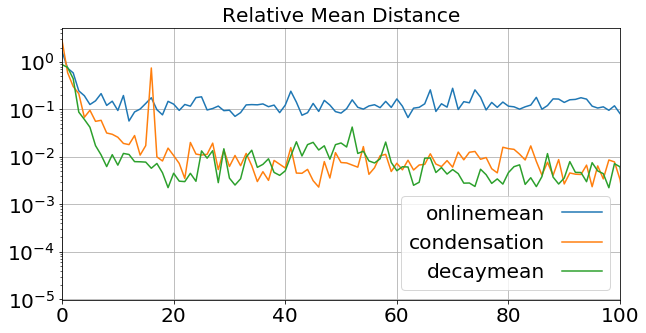

In [23]:
import matplotlib.pylab as pylab
params = {'font.size' : 14,
          'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.plot(np.arange(0,251),M)
plt.legend([m.split('_')[0] for m in methodsname],markerfirst=False,loc="lower right")
plt.xlim(0,100)
plt.yscale("log")
plt.grid()
plt.title("Relative Mean Distance")
plt.savefig("./exp_cifar10_rmd.pdf",dpi=250,bbox_inches="tight",pad_inches=0.1,transparent=False,facecolor='w')
plt.show()

In [ ]:
[m.split('_')[0] for m in methods]